In [1]:
%%capture
!python -m pip install  Pillow numpy imageio opencv-python mat4py pymatreader bisect
!python -m pip install numba scipy h5py matplotlib  pymatreader 

In [1]:
from PIL import Image, ImageDraw, ImageStat
import numpy as np
import cv2
import bisect
from numba import jit
import os 
import IPython.display #import Image
import matplotlib.pyplot as plt

### 1

#### Начальные данные и методы

In [2]:
task = 1
SOURCE_PIC =r"C:\Users\Dmitry\Desktop\M8\Matlab\HomeWorkProjects\LW_2\Task_08\Pictures" 

OUTPUT_PIC= os.path.join(SOURCE_PIC,f"task_{task}_OUT")

if not os.path.exists(OUTPUT_PIC):
    os.makedirs(OUTPUT_PIC)
    
pic = "Img2_08_1.jpg"
    
SOURCE_FILE = os.path.join(SOURCE_PIC,pic)

In [3]:
def imflatfield(I, sigma):
    """Python equivalent imflatfield implementation
       I format must be BGR and type of I must be uint8"""
    A = I.astype(np.float32) / 255  # A = im2single(I);
    Ihsv = cv2.cvtColor(A, cv2.COLOR_BGR2HSV)  # Ihsv = rgb2hsv(A);
    A = Ihsv[:, :, 2]  # A = Ihsv(:,:,3);

    filterSize = int(2*np.ceil(2*sigma) + 1);  # filterSize = 2*ceil(2*sigma)+1;

    # shading = imgaussfilt(A, sigma, 'Padding', 'symmetric', 'FilterSize', filterSize); % Calculate shading
    shading = cv2.GaussianBlur(A, (filterSize, filterSize), sigma, borderType=cv2.BORDER_REFLECT)

    meanVal = np.mean(A)  # meanVal = mean(A(:),'omitnan')

    #% Limit minimum to 1e-6 instead of testing using isnan and isinf after division.
    shading = np.maximum(shading, 1e-6)  # shading = max(shading, 1e-6);

    B = A*meanVal / shading  # B = A*meanVal./shading;

    #% Put processed V channel back into HSV image, convert to RGB
    Ihsv[:, :, 2] = B  # Ihsv(:,:,3) = B;

    B = cv2.cvtColor(Ihsv, cv2.COLOR_HSV2BGR)  # B = hsv2rgb(Ihsv);

    B = np.round(np.clip(B*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);

    return B
 
def make_noisy_image(OUTPUT_DIR:str,FILE:str,loc:float=0,scale:float=1)-> str:
    img = cv2.imread(FILE)

    # Получение ширины, высоты и количество каналов изображения
    h, w, _ = img.shape

    # Создание сетки из точек вокруг центра изображения
    x, y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))

    # Вычисление расстояния каждой точки сетки от центра изображения
    radius = np.sqrt(x**2 + y**2)

    # Нормализация радиуса для создания градиента яркости
    radius = (radius - radius.min()) / (radius.max() - radius.min())
    np.random.normal()
    # Создание маски, которая определяет область имитации неравномерной засветки
    mask = np.random.normal(loc=0,scale=1,size=(h, w))
    mask[radius > 0.95] = 0

    # Накладывание маски на изображение и сохранение результата
    result = cv2.merge([img[:,:,0]*mask, img[:,:,1]*mask, img[:,:,2]*mask])
    cv2.imwrite(os.path.join(OUTPUT_DIR,f"NoiseImage(loc={loc}-scale={scale}).jpg"), result)
    return os.path.join(OUTPUT_DIR,f"NoiseImage(loc={loc}-scale={scale}).jpg")

def make_dark_spot(OUTPUT_DIR:str,FILE:str):
    # Загружаем изображение в оттенках серого
    name = os.path.split(FILE)[-1]
    img_gray = cv2.imread(FILE, cv2.IMREAD_GRAYSCALE)

    # Получаем размеры изображения
    height, width = img_gray.shape

    # Вычисляем центр изображения
    center_x = int(width/2)
    center_y = int(height/2)

    # Создаем новое черное изображение
    result = np.zeros((height, width), np.uint8)

    # Проходимся по всем пикселям изображения
    for x in range(width):
        for y in range(height):
            # Вычисляем расстояние до центра
            distance = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
            radius = ((height - center_x) ** 2 + (width - center_y) ** 2) ** 0.5
            # Нормализуем расстояние, получаем значение от 0 до 1
            norm_distance = distance / radius
            
            # Вычисляем яркость пикселя на основе обратно пропорционального значения нормализованного расстояния
            brightness = int(255 * (norm_distance)) if norm_distance !=0 else 1e-10
            
            # Применяем яркость к пикселю изображения
            result[y, x] = img_gray[y, x] * brightness // 255

    # Показываем результат и сохраняем его
    cv2.imwrite(os.path.join(OUTPUT_DIR,f"WithDarkSpot_{name}"), result)
    return os.path.join(OUTPUT_DIR,f"WithDarkSpot_{name}")

#### Example of Histograms Equalization

In [14]:

# import Opencv
import cv2
  
# import Numpy
import numpy as np
  
# read a image using imread
img = cv2.imread(SOURCE_FILE, 0)
  
# creating a Histograms Equalization
# of a image using cv2.equalizeHist()
equ = cv2.equalizeHist(img)
cv2.imwrite(os.path.join(OUTPUT_PIC , f"HIST_EX_{pic}"), img)
# # stacking images side-by-side
# res = np.hstack((img, equ))
  
# # show image input vs output
# cv2.imshow(OUTPUT_PIC, res)
  
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

#### MAIN


In [6]:
img =  cv2.imread(make_dark_spot(OUTPUT_PIC,SOURCE_FILE), 0)
img = cv2.equalizeHist(img, 0)
OUTPUT_ImFlatField = os.path.join(OUTPUT_PIC ,"ImFlatField")
if not os.path.exists(OUTPUT_ImFlatField):
    os.makedirs(OUTPUT_ImFlatField)
HISTED_file = os.path.join(OUTPUT_ImFlatField ,f"HIST_{pic}")
cv2.imwrite(HISTED_file, img)

I = cv2.imread(HISTED_file)
for sigma in range(30,300,30):
    flatField_file = os.path.join(OUTPUT_ImFlatField ,f"(sigma,{sigma})_{pic}")
    test = imflatfield(I, sigma)

    cv2.imwrite(flatField_file, test)

### 2

#### Начальные данные

Для определения динамического диапазона яркостей изображения можно использовать функцию `imadjust` из библиотеки Image Processing Toolbox в MATLAB. Эта функция позволяет регулировать контрастность изображения.

Чтобы выбрать подходящее нелинейное преобразование для сохранения всех деталей изображения, можно воспользоваться функцией `histeq`, которая выполняет гистограммное выравнивание изображения. Она позволит увеличить контраст и сохранить детали как в центре, так и на краях изображения.

In [7]:
task = 2
SOURCE =r"C:\Users\Dmitry\Desktop\M8\Matlab\HomeWorkProjects\LW_2\Task_08\Pictures" 

OUTPUT= os.path.join(SOURCE,f"task_{task}_OUT")

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
file = os.path.join(SOURCE,"Z2_08_2.mat")


MAT_RAW = np.loadtxt(file)
MAT_RAW_FIX =  MAT_RAW * 255
  
print(f"MAT_RAW: {MAT_RAW.shape}\nmax(MAT_RAW) = {MAT_RAW.max()}\nmin(MAT_RAW) = {MAT_RAW.min()}")
np.savetxt('MAT_RAW.txt', MAT_RAW, delimiter=',')

MAT_RAW: (1001, 1001)
max(MAT_RAW) = 1.0
min(MAT_RAW) = 4.3349039e-09


In [8]:
@jit
def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(256)),range=(0,255))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, 256): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

Исходное изображение

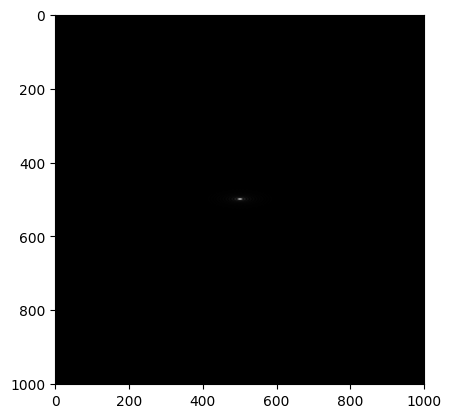

In [9]:
from matplotlib.pyplot import imshow

MAT = MAT_RAW_FIX.reshape(*MAT_RAW_FIX.shape).astype(np.uint8)

MAT = np.stack((MAT,) * 3, axis=-1)
image_raw = Image.fromarray(MAT)
image_raw.save(os.path.join(OUTPUT,"raw_image.png"))
%matplotlib inline
imshow(image_raw)

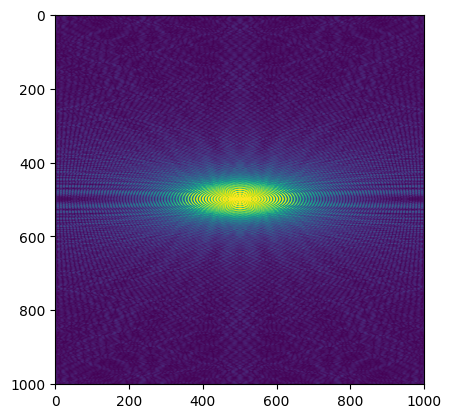

In [11]:
from matplotlib.pyplot import imshow

for tol_i in range(5,100,10):
    tol = tol_i/100
    image = imadjust(MAT_RAW_FIX,tol=tol)
    MAT = image.reshape(*image.shape).astype(np.uint8)
    MAT = np.stack((MAT,) * 3, axis=-1)
    image_data = Image.fromarray(MAT)
    image_data.save(os.path.join(OUTPUT,f"Tol({tol})_image.png"))

%matplotlib inline
image = imadjust(MAT_RAW_FIX)
imshow(image)

### 3

Задание
* Дано изображение `Img2_08_3.jpg`. 
* Постройте гистограмму яркости заданного изображения.
* Используйте функцию `imadjust` для коррекции контраста.
* Постройте гистограмму яркости скорректированного изображения.
* Сравните гистограммы яркостей обоих изображений и сделайте выводы.
* Используйте функцию `histeq` для эквализации гистограммы.
* Постройте гистограмму яркости после эквализации. Сравните гистограммы яркостей, полученные в результате использования функций `imadjust`  и   `histeq`.
* Используйте функцию `imlocalbrighten` для улучшения контраста. Постройте гистограмму скорректированного изображения.
* Используйте функцию `imcontrast` для улучшения яркости и контраста. Постройте гистограмму скорректированного изображения.

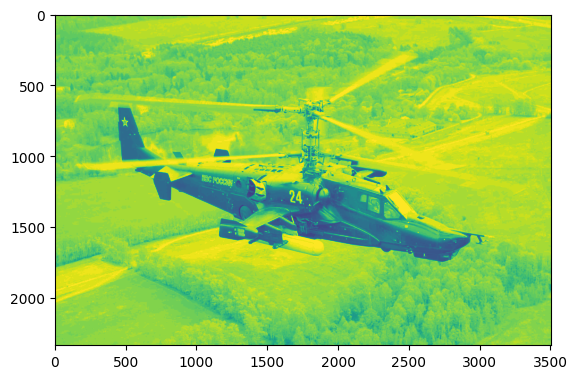

In [ ]:
task = 3
SOURCE_PIC_3 =r"C:\Users\Dmitry\Desktop\M8\Matlab\HomeWorkProjects\LW_2\Task_08\Pictures" 

OUTPUT_PIC_3= os.path.join(SOURCE_PIC_3,f"task_{task}_OUT")

if not os.path.exists(OUTPUT_PIC_3):
    os.makedirs(OUTPUT_PIC_3)
    
pic = "Img2_08_3.jpg"
    
SOURCE_FILE_3 = os.path.join(SOURCE_PIC_3,pic)

import matplotlib.image as mpimg
img = mpimg.imread(SOURCE_FILE_3)
imgplot = plt.imshow(img)
plt.show()

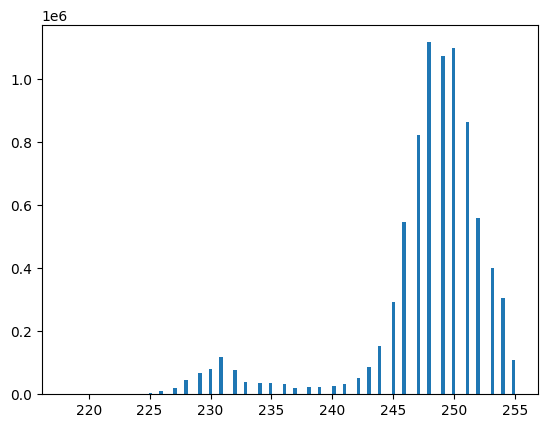

In [49]:

def color_hist(filename):
    img = np.asarray(Image.open(filename).convert("L")).reshape(-1,1)
    plt.hist(img, bins=128)
    plt.show()

color_hist(SOURCE_FILE_3)

In [89]:
tol = 1/2+12.5/2
saved_image_path = os.path.join(OUTPUT_PIC_3,f"IMADJUST_(tol={tol})_{pic}")


image = Image.open(SOURCE_FILE_3)
arr = np.asarray(image)
arr2=imadjust(arr,tol=tol)
new_im = Image.fromarray(arr2)
if new_im.mode != 'RGB':
    new_im = new_im.convert('RGB')
new_im.save(saved_image_path)

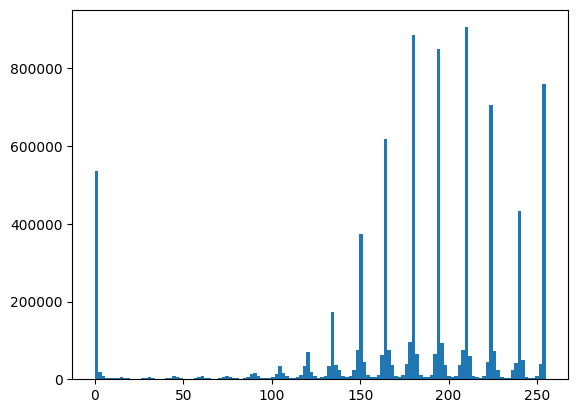

In [90]:
color_hist(saved_image_path)

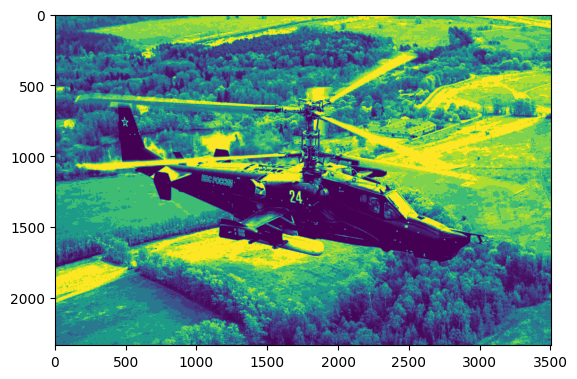

-1

In [91]:
img = cv2.imread(saved_image_path, 0)
  
# creating a Histograms Equalization
# of a image using cv2.equalizeHist()
equ = cv2.equalizeHist(img)

saved_image_path_equlize = os.path.join(OUTPUT_PIC_3,f"EQUALIZED_{pic}")

imgplot = plt.imshow(equ)
plt.show()
cv2.imwrite(saved_image_path_equlize, equ)
cv2.waitKey(0)

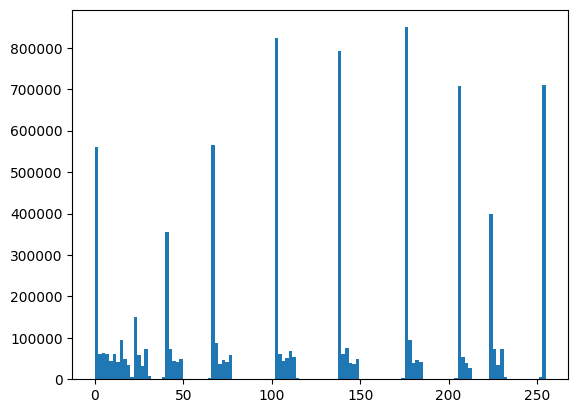

In [92]:
color_hist(saved_image_path_equlize)

In [103]:
def my_imlocalbrighten(
    FILE:str=saved_image_path_equlize,
    val:int=45,
    OUTPUT:str=OUTPUT_PIC_3
    ):
    
    name = os.path.split(FILE)[-1]
    # Open the image
    im = Image.open(FILE)

    # Convert to HSV colourspace and split channels for ease of separate processing
    H, S, V = im.convert('HSV').split()

    # Increase the brightness, or Value channel
    # Change 30 to 50 for bigger effect, or 10 for smaller effect
    newV = V.point(lambda i: i + int(val*(255-i)/255))

    # Recombine channels and convert back to RGB
    res = Image.merge(mode="HSV", bands=(H,S,newV)).convert('RGB')
    
    res.save(os.path.join(OUTPUT,f"imlocalbrighten_{name}"))
    return os.path.join(OUTPUT,f"imlocalbrighten_{name}")

path_imlocalbrighten = my_imlocalbrighten(saved_image_path_equlize,OUTPUT=OUTPUT_PIC_3)

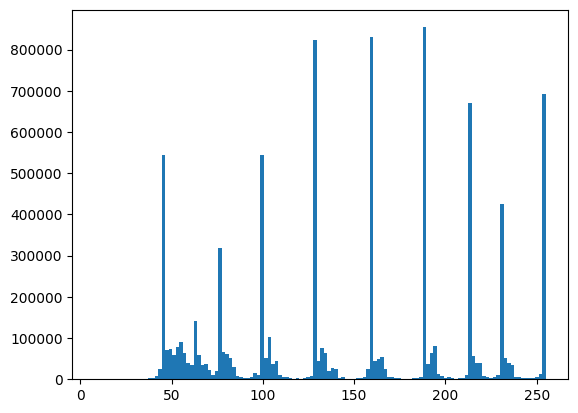

In [104]:
color_hist(path_imlocalbrighten)

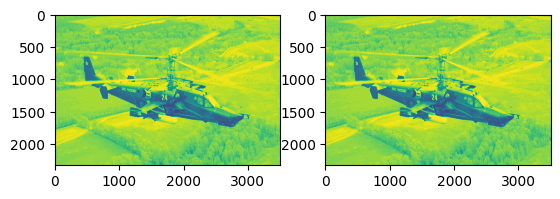

In [ ]:

im1 = Image.open(SOURCE_FILE_3)
images_list = [im1]
N_levels = 2
for i in range(N_levels):
    image_i = change_contrast(im1,level = 100/N_levels * i)
    images_list.append(image_i)
    
f, axarr = plt.subplots(1,N_levels) 
for i in range(N_levels):
    im = images_list[i]
    axarr[i].imshow(im)
# axarr[1].imshow(res)

In [105]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


In [106]:
Brightness = float(input("Change Brightness: "))
Contrast = float(input("Change Contrast: "))

image1 = cv2.imread(SOURCE_FILE_3)
images_list = [image]
image2 = apply_brightness_contrast(img, Brightness, Contrast)
images_list.append(image2)


f, axarr = plt.subplots(1,len(images_list)) 
for i in range(len(images_list)):
    im = images_list[i]
    axarr[i].imshow(im)

ValueError: could not convert string to float: ''